# Mushroom Midterm
### Predicting the edibility of mushrooms
### Philip Fowler
### date started: 2025-03-17


In [161]:
# import libraries
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import chi2, SelectKBest, RFE
from sklearn.metrics import recall_score, precision_score, f1_score, classification_report, confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC

dont_panic = 42
warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

In [137]:
# fetch dataset 
mushroom = fetch_ucirepo(id=73) 
  
# data (as pandas dataframes) 
x = mushroom.data.features 
y = mushroom.data.targets 
  
# metadata 
print(mushroom.metadata) 
# I love that UCI includes this metadata.  It is in the readme as it is easier to access there.



{'uci_id': 73, 'name': 'Mushroom', 'repository_url': 'https://archive.ics.uci.edu/dataset/73/mushroom', 'data_url': 'https://archive.ics.uci.edu/static/public/73/data.csv', 'abstract': 'From Audobon Society Field Guide; mushrooms described in terms of physical characteristics; classification: poisonous or edible', 'area': 'Biology', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 8124, 'num_features': 22, 'feature_types': ['Categorical'], 'demographics': [], 'target_col': ['poisonous'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1981, 'last_updated': 'Thu Aug 10 2023', 'dataset_doi': '10.24432/C5959T', 'creators': [], 'intro_paper': None, 'additional_info': {'summary': "This data set includes descriptions of hypothetical samples corresponding to 23 species of gilled mushrooms in the Agaricus and Lepiota Family (pp. 500-525).  Each species is identified as definitely edible, definitely po

# Examine and clean the data

In [138]:
# variable information 
print(mushroom.variables) 

                        name     role         type demographic  \
0                  poisonous   Target  Categorical        None   
1                  cap-shape  Feature  Categorical        None   
2                cap-surface  Feature  Categorical        None   
3                  cap-color  Feature       Binary        None   
4                    bruises  Feature  Categorical        None   
5                       odor  Feature  Categorical        None   
6            gill-attachment  Feature  Categorical        None   
7               gill-spacing  Feature  Categorical        None   
8                  gill-size  Feature  Categorical        None   
9                 gill-color  Feature  Categorical        None   
10               stalk-shape  Feature  Categorical        None   
11                stalk-root  Feature  Categorical        None   
12  stalk-surface-above-ring  Feature  Categorical        None   
13  stalk-surface-below-ring  Feature  Categorical        None   
14    stal

In [139]:
# The features we will use in our model.  
x.head()

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,x,s,n,t,p,f,c,n,k,e,...,s,w,w,p,w,o,p,k,s,u
1,x,s,y,t,a,f,c,b,k,e,...,s,w,w,p,w,o,p,n,n,g
2,b,s,w,t,l,f,c,b,n,e,...,s,w,w,p,w,o,p,n,n,m
3,x,y,w,t,p,f,c,n,n,e,...,s,w,w,p,w,o,p,k,s,u
4,x,s,g,f,n,f,w,b,k,t,...,s,w,w,p,w,o,e,n,a,g


In [140]:
# Our target variable.
y.head()

,poisonous
0,p
1,e
2,e
3,p
4,e


In [141]:
# How many rows and columns?
x.shape

(8124, 22)

In [142]:
y.shape

(8124, 1)

In [143]:
# Let's get some descriptive statistics.
x.describe().T

,count,unique,top,freq
cap-shape,8124,6,x,3656
cap-surface,8124,4,y,3244
cap-color,8124,10,n,2284
bruises,8124,2,f,4748
odor,8124,9,n,3528
gill-attachment,8124,2,f,7914
gill-spacing,8124,2,c,6812
gill-size,8124,2,b,5612
gill-color,8124,12,b,1728
stalk-shape,8124,2,t,4608


In [144]:
y.describe().T

,count,unique,top,freq
poisonous,8124,2,e,4208


In [145]:
# Do we have nulls?
x.isnull().sum()

cap-shape                      0
cap-surface                    0
cap-color                      0
bruises                        0
odor                           0
gill-attachment                0
gill-spacing                   0
gill-size                      0
gill-color                     0
stalk-shape                    0
stalk-root                  2480
stalk-surface-above-ring       0
stalk-surface-below-ring       0
stalk-color-above-ring         0
stalk-color-below-ring         0
veil-type                      0
veil-color                     0
ring-number                    0
ring-type                      0
spore-print-color              0
population                     0
habitat                        0
dtype: int64

In [146]:
# Frequency of unique values for stalk-root
stalk_root_counts = x['stalk-root'].value_counts()
print(stalk_root_counts)

stalk-root
b    3776
e    1120
c     556
r     192
Name: count, dtype: int64


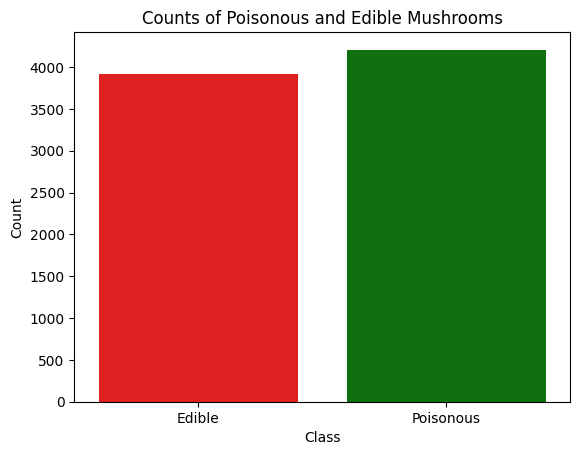

In [160]:
# Count the occurrences of each class in the target variable
class_counts = y['poisonous'].value_counts()

# Plot the bar chart using seaborn
sns.countplot(x='poisonous', data=y, palette=['red', 'green'])
plt.title('Counts of Poisonous and Edible Mushrooms')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Edible', 'Poisonous'], rotation=0)
plt.show()

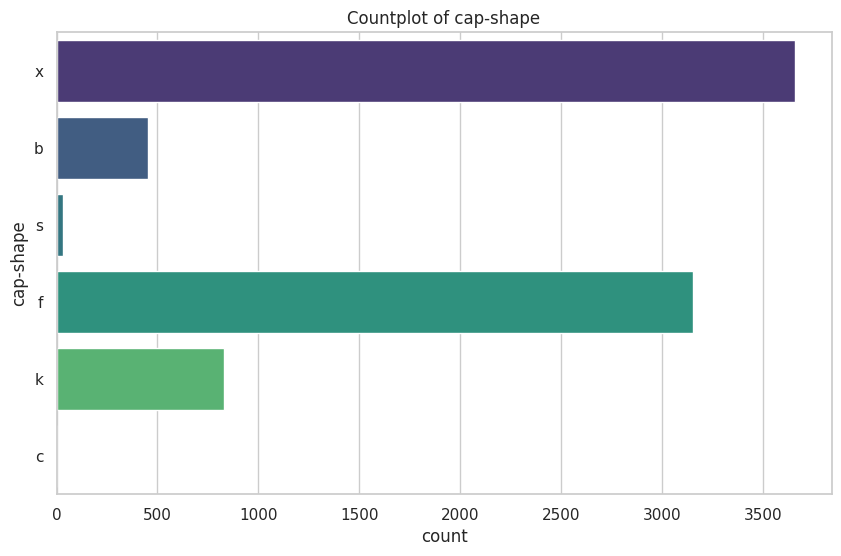

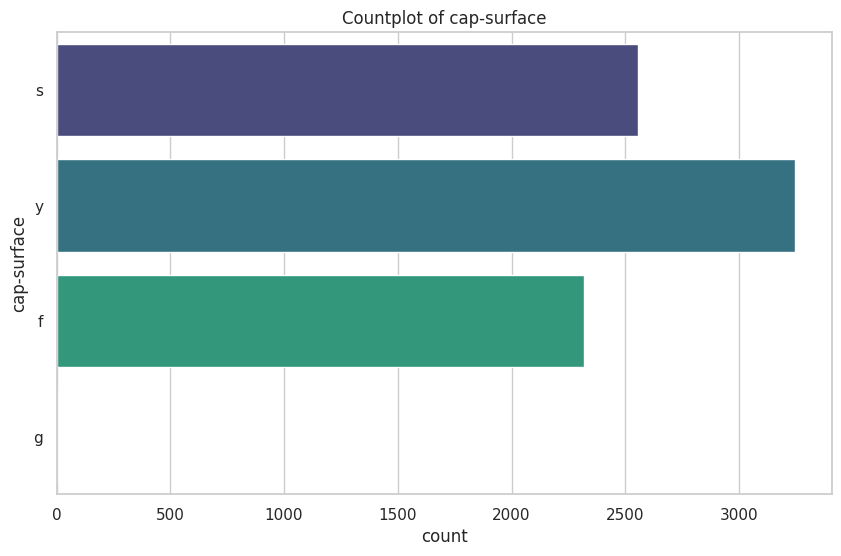

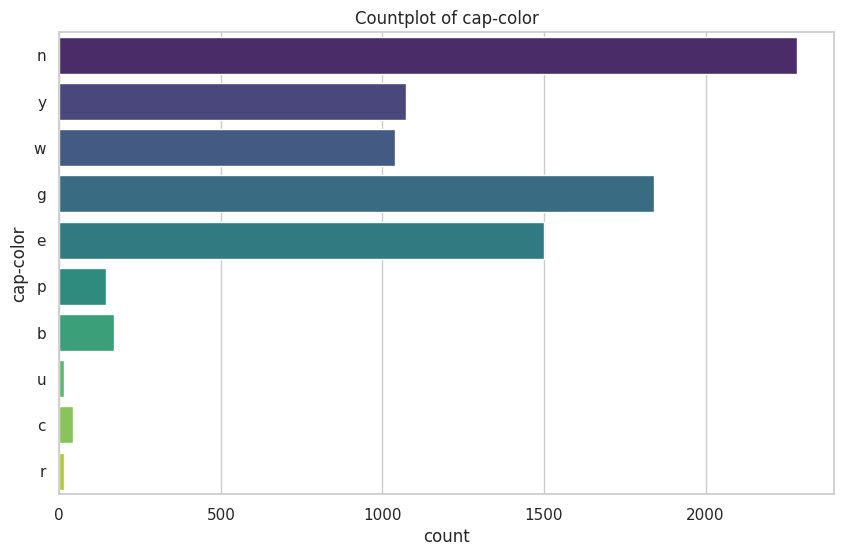

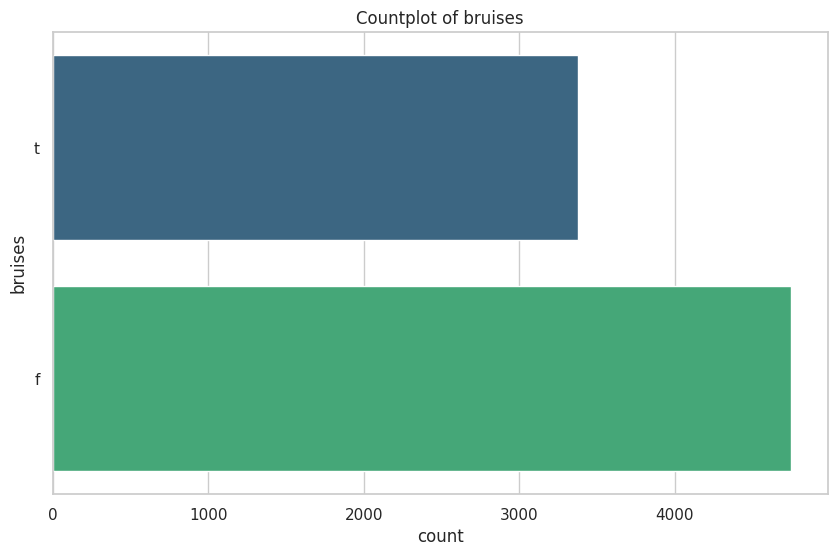

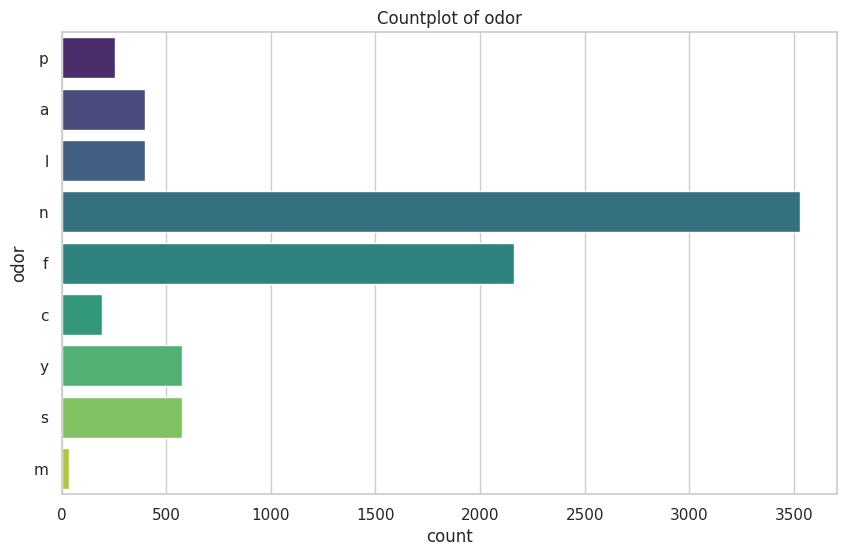

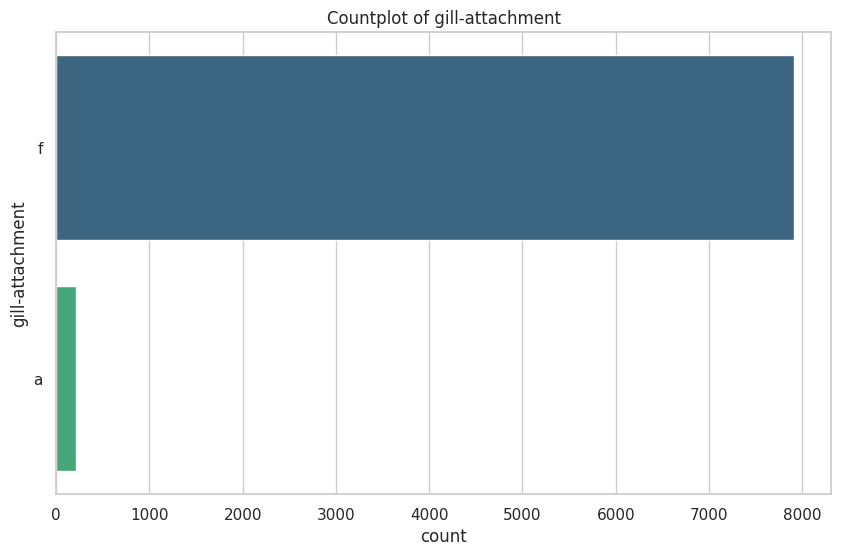

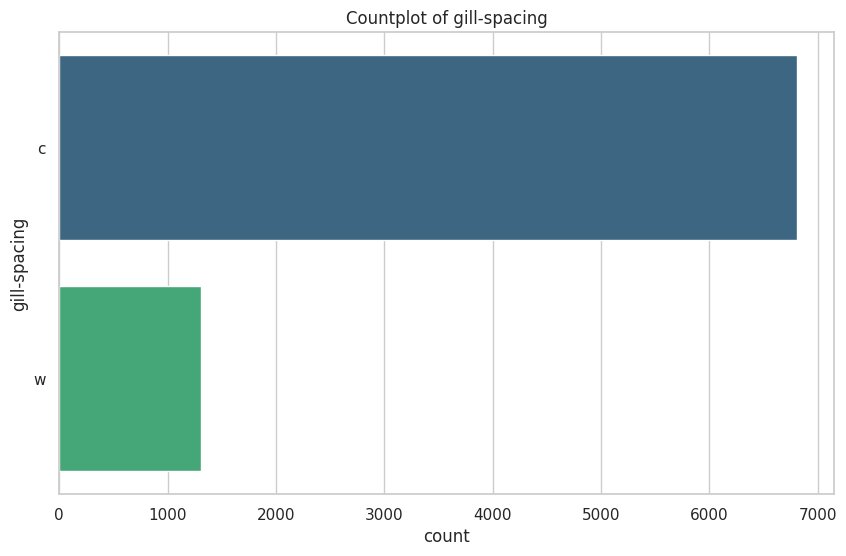

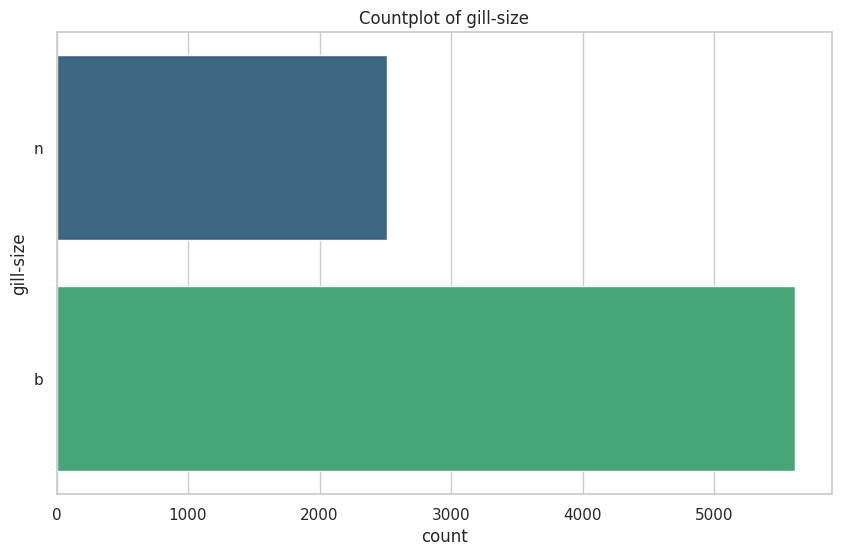

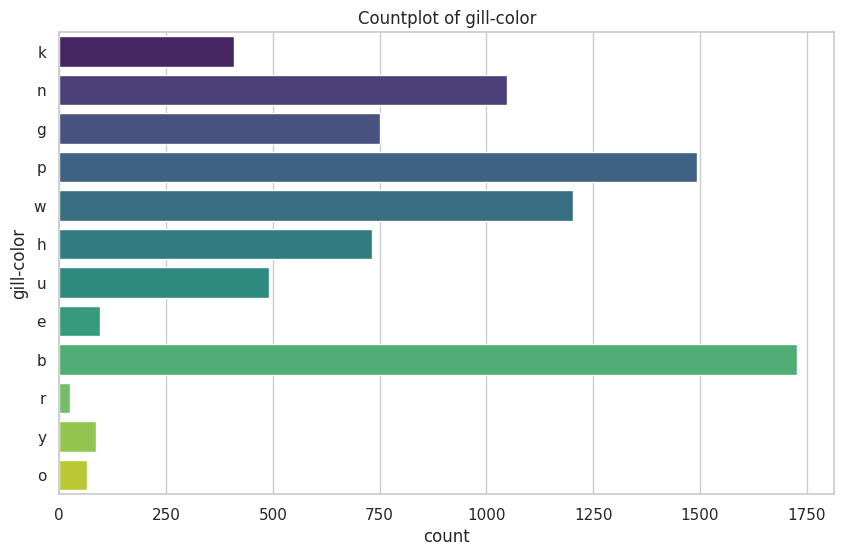

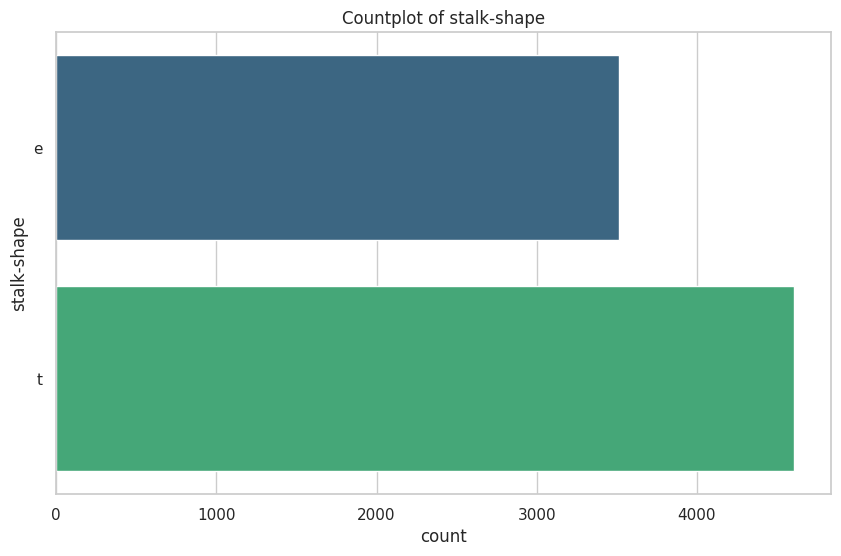

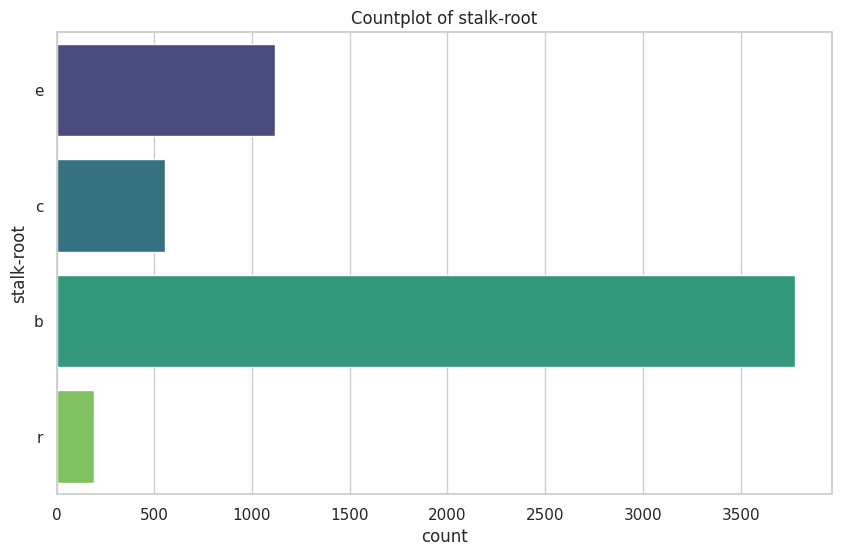

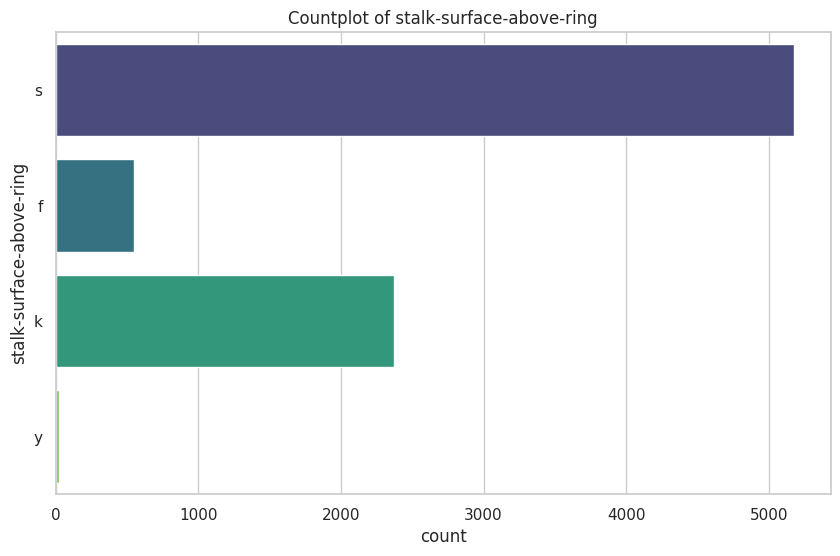

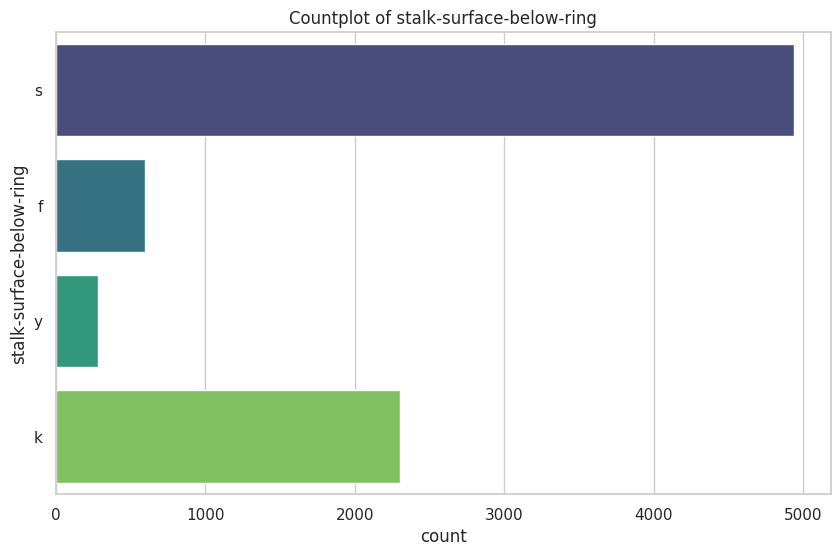

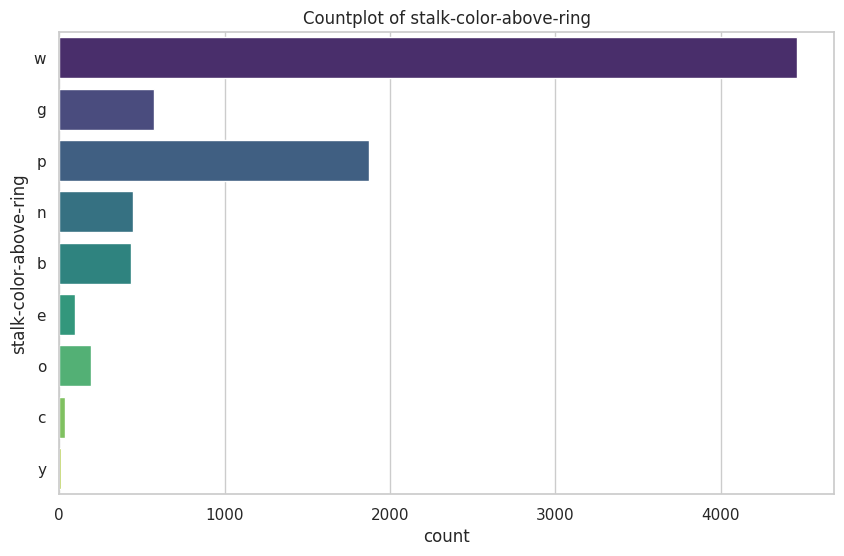

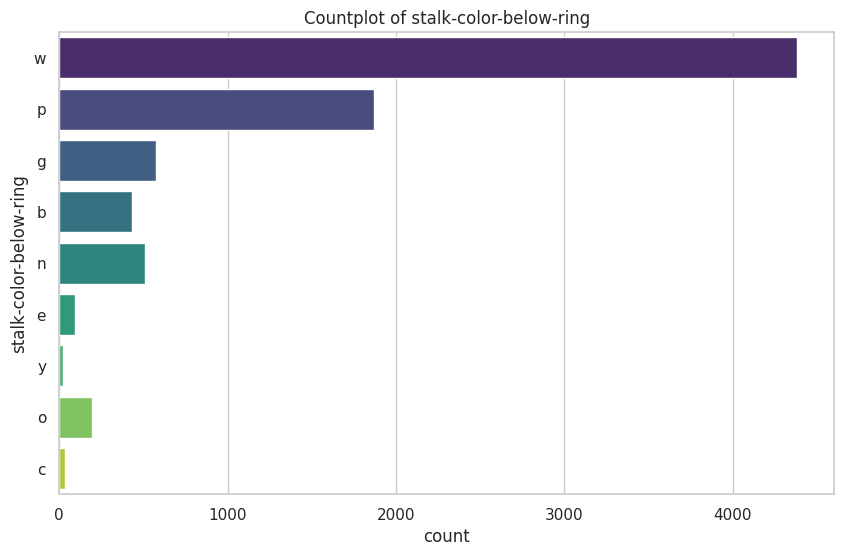

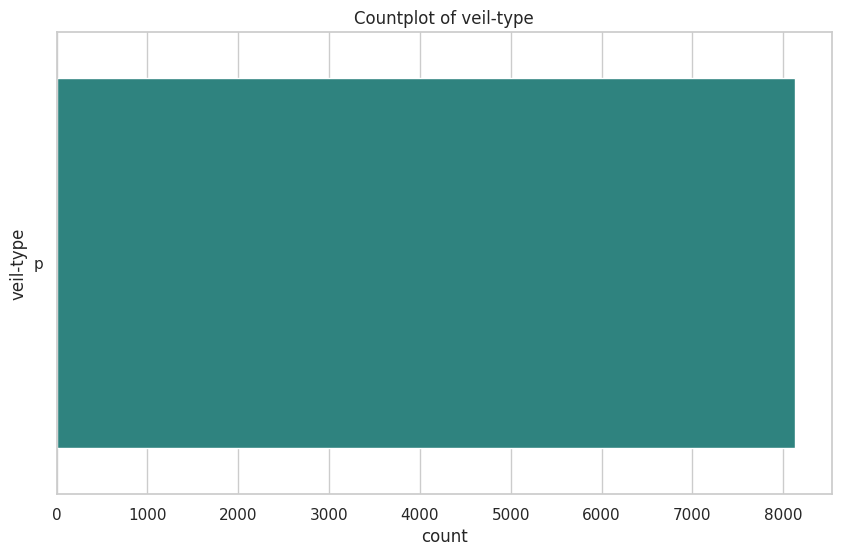

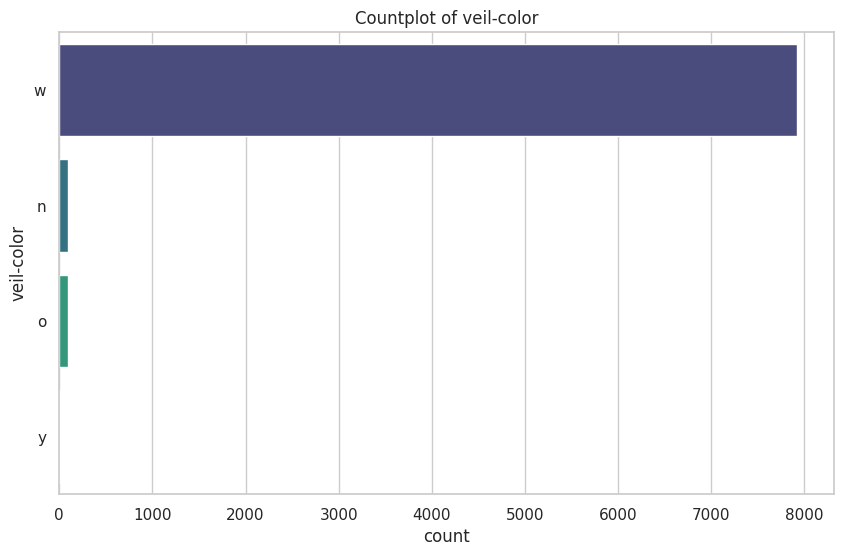

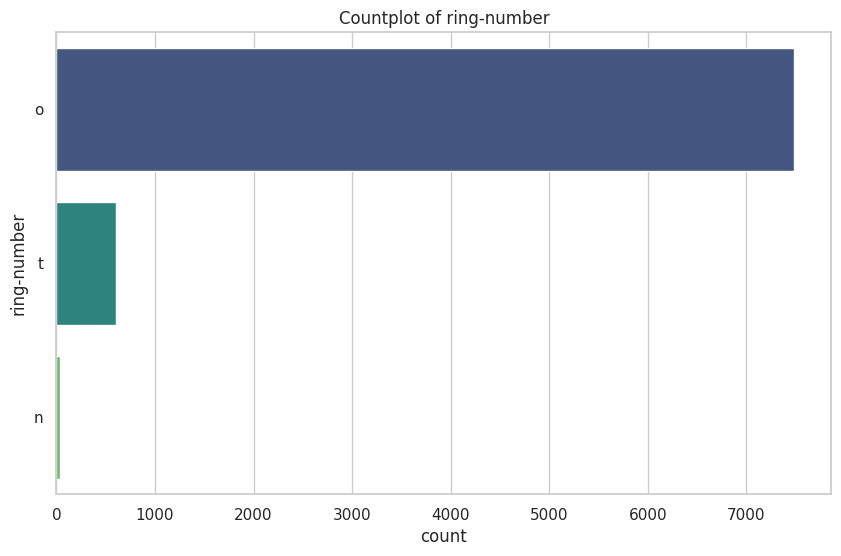

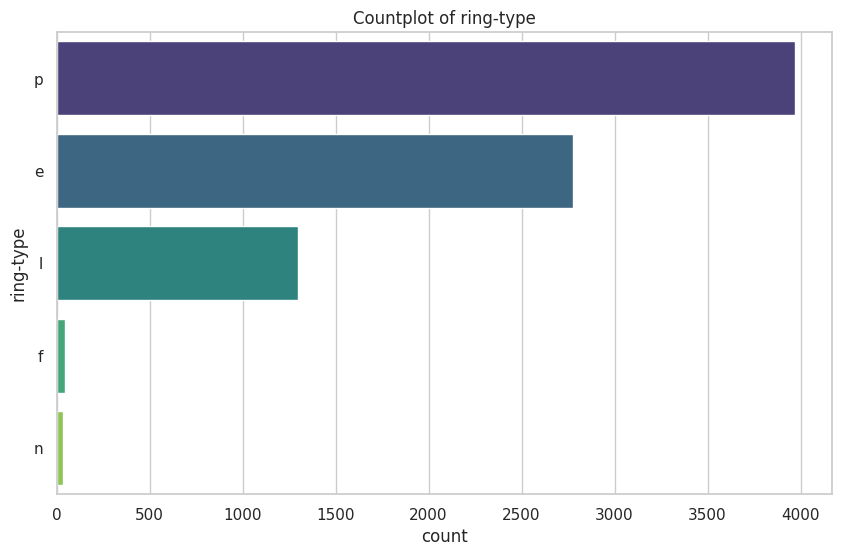

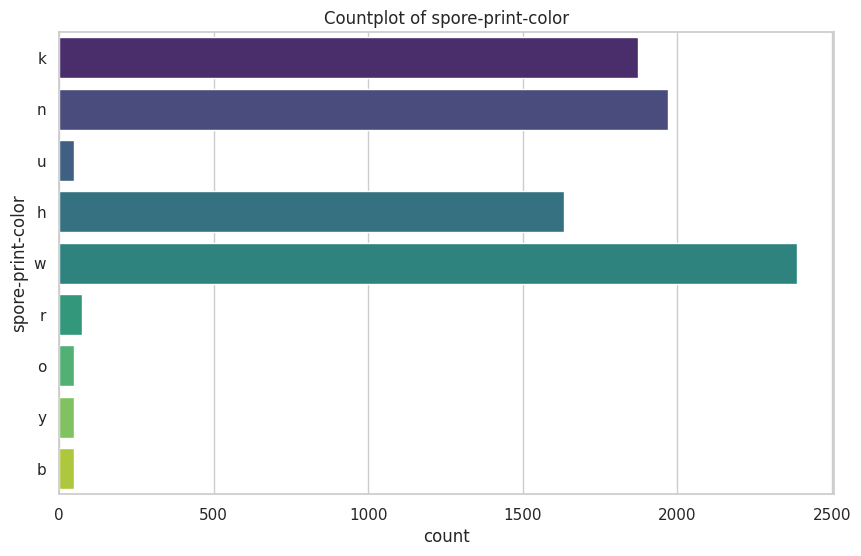

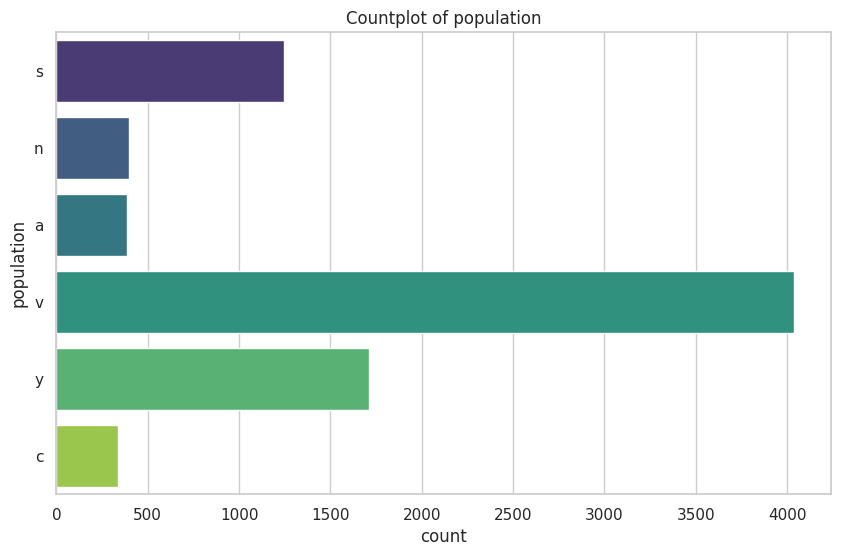

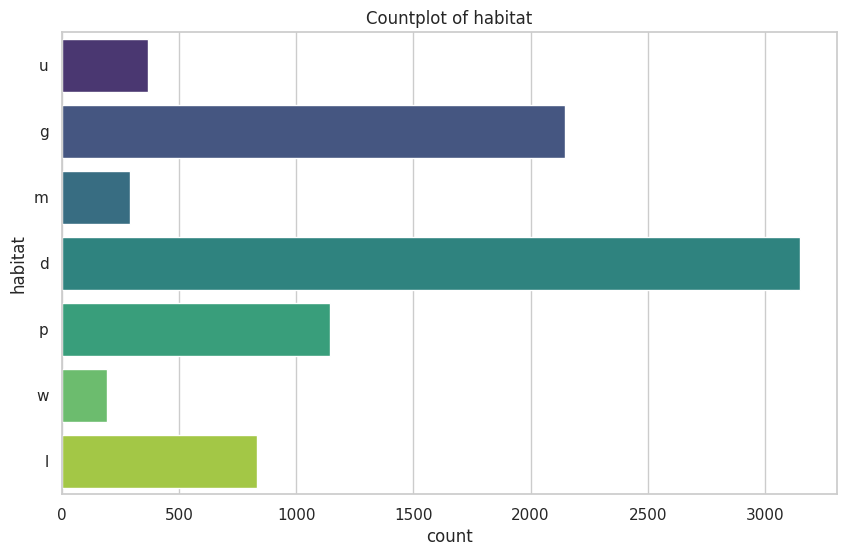

In [162]:
# Create countplots for each column in the x dataframe
for column in x.columns:
    plt.figure(figsize=(10, 6))
    sns.countplot(y=column, data=x, palette='viridis')
    plt.title(f'Countplot of {column}')
    plt.show()

# Data Coding and Feature Selection

In [148]:
# 1) Make a copy of x and name it x_uncleaned
x_uncleaned = x.copy()

# 2) Drop the column stalk-root and name it x_dropcolumn
x_dropcolumn = x.drop(columns=['stalk-root'])



In [149]:
# Encode categorical features as numbers
x_encoded = x.apply(LabelEncoder().fit_transform)

# Perform chi-squared test
chi2_scores, p_values = chi2(x_encoded, y.apply(LabelEncoder().fit_transform))

# Create a DataFrame to display the results
chi2_results = pd.DataFrame({'Feature': x.columns, 'Chi2 Score': chi2_scores, 'p-value': p_values})

# Display the results
print(chi2_results.sort_values(by='p-value'))

                     Feature   Chi2 Score        p-value
7                  gill-size  1636.606833   0.000000e+00
8                 gill-color  5957.764469   0.000000e+00
18                 ring-type  1950.610146   0.000000e+00
3                    bruises  1194.277352  1.069037e-261
6               gill-spacing   826.795274  8.061293e-182
21                   habitat   751.309489  2.082916e-165
10                stalk-root   425.896927   1.270374e-94
19         spore-print-color   379.132729   1.922119e-84
20                population   311.766736   9.002366e-70
11  stalk-surface-above-ring   222.982400   2.022392e-50
1                cap-surface   214.068544   1.779362e-48
12  stalk-surface-below-ring   206.648180   7.398869e-47
13    stalk-color-above-ring   119.792216   7.024638e-28
14    stalk-color-below-ring   109.789410   1.089740e-25
4                       odor    75.910163   2.968682e-18
9                stalk-shape    36.594105   1.454709e-09
17               ring-number   

In [150]:
# Initialize the model
model = LogisticRegression()

# Initialize RFE with the model and the number of features to select
rfe = RFE(model, n_features_to_select=10)

# Fit RFE
rfe = rfe.fit(x_encoded, y.apply(LabelEncoder().fit_transform))

# Get the ranking of the features
ranking = rfe.ranking_

# Create a DataFrame to display the feature rankings
feature_ranking = pd.DataFrame({'Feature': x.columns, 'Ranking': ranking})

# Display the features and their rankings
print(feature_ranking.sort_values(by='Ranking'))

                     Feature  Ranking
3                    bruises        1
7                  gill-size        1
6               gill-spacing        1
5            gill-attachment        1
10                stalk-root        1
11  stalk-surface-above-ring        1
9                stalk-shape        1
17               ring-number        1
18                 ring-type        1
20                population        1
16                veil-color        2
4                       odor        3
1                cap-surface        4
12  stalk-surface-below-ring        5
8                 gill-color        6
13    stalk-color-above-ring        7
14    stalk-color-below-ring        8
0                  cap-shape        9
19         spore-print-color       10
21                   habitat       11
2                  cap-color       12
15                 veil-type       13


In [151]:
# Get the top 10 features from chi2 test
top_10_chi2 = chi2_results.sort_values(by='p-value').head(10)

# Get the top 10 features from RFE
top_10_rfe = feature_ranking[feature_ranking['Ranking'] == 1]

# Combine the results
combined_top_features = pd.concat([top_10_chi2, top_10_rfe], axis=0).drop_duplicates().reset_index(drop=True)

# Display the combined top features
print(combined_top_features)

                     Feature   Chi2 Score        p-value  Ranking
0                  gill-size  1636.606833   0.000000e+00      NaN
1                 gill-color  5957.764469   0.000000e+00      NaN
2                  ring-type  1950.610146   0.000000e+00      NaN
3                    bruises  1194.277352  1.069037e-261      NaN
4               gill-spacing   826.795274  8.061293e-182      NaN
5                    habitat   751.309489  2.082916e-165      NaN
6                 stalk-root   425.896927   1.270374e-94      NaN
7          spore-print-color   379.132729   1.922119e-84      NaN
8                 population   311.766736   9.002366e-70      NaN
9   stalk-surface-above-ring   222.982400   2.022392e-50      NaN
10                   bruises          NaN            NaN      1.0
11           gill-attachment          NaN            NaN      1.0
12              gill-spacing          NaN            NaN      1.0
13                 gill-size          NaN            NaN      1.0
14        

In [152]:
# 3) Make a copy of x with only the top 10 features and name it x_top10
x_top10 = x[['odor', 'spore-print-color', 'gill-size', 'gill-color', 'ring-type', 'bruises', 'stalk-surface-above-ring', 'stalk-surface-below-ring', 'population', 'habitat']]
x_top10.head()




,odor,spore-print-color,gill-size,gill-color,ring-type,bruises,stalk-surface-above-ring,stalk-surface-below-ring,population,habitat
0,p,k,n,k,p,t,s,s,s,u
1,a,n,b,k,p,t,s,s,n,g
2,l,n,b,n,p,t,s,s,n,m
3,p,k,n,n,p,t,s,s,s,u
4,n,n,b,k,e,f,s,s,a,g


In [153]:
# 4) Make a copy of x with only the top 5 features and name it x_top5
x_top5 = x[['odor', 'spore-print-color', 'gill-size', 'gill-color', 'ring-type']]
x_top5.head()

,odor,spore-print-color,gill-size,gill-color,ring-type
0,p,k,n,k,p
1,a,n,b,k,p
2,l,n,b,n,p
3,p,k,n,n,p
4,n,n,b,k,e


In [154]:
# One-hot encode the datasets
x_uncleaned_encoded = pd.get_dummies(datasets['Uncleaned'])
x_dropcolumn_encoded = pd.get_dummies(datasets['Drop Column'])
x_top10_encoded = pd.get_dummies(datasets['Top 10 Features'])
x_top5_encoded = pd.get_dummies(datasets['Top 5 Features'])

# Display the first few rows of each encoded dataset
print(x_uncleaned_encoded.head())
print(x_dropcolumn_encoded.head())
print(x_top10_encoded.head())
print(x_top5_encoded.head())

   cap-shape_b  cap-shape_c  cap-shape_f  cap-shape_k  cap-shape_s  \
0        False        False        False        False        False   
1        False        False        False        False        False   
2         True        False        False        False        False   
3        False        False        False        False        False   
4        False        False        False        False        False   

   cap-shape_x  cap-surface_f  cap-surface_g  cap-surface_s  cap-surface_y  \
0         True          False          False           True          False   
1         True          False          False           True          False   
2        False          False          False           True          False   
3         True          False          False          False           True   
4         True          False          False           True          False   

   ...  population_s  population_v  population_y  habitat_d  habitat_g  \
0  ...          True         False  

# Models


In [155]:
# Prepare one-hot encoded datasets
datasets_encoded = {
    'Uncleaned': x_uncleaned_encoded,
    'Drop Column': x_dropcolumn_encoded,
    'Top 10 Features': x_top10_encoded,
    'Top 5 Features': x_top5_encoded
}

# Function to train and evaluate models
def evaluate_models(x_train, y_train, x_test, y_test):
    models = {
        'Logistic Regression': LogisticRegression(),
        'Decision Tree': DecisionTreeClassifier(),
        'SVM': SVC(kernel='linear')
    }
    
    results = {}
    
    for model_name, model in models.items():
        model.fit(x_train, y_train)
        predictions = model.predict(x_test)
        
        accuracy = accuracy_score(y_test, predictions)
        precision = precision_score(y_test, predictions)
        recall = recall_score(y_test, predictions)
        f1 = f1_score(y_test, predictions)
        confusion = confusion_matrix(y_test, predictions)
        
        results[model_name] = {
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1,
            'Confusion Matrix': confusion
        }
    
    return results

# Encode target variable
y_encoded = y.apply(LabelEncoder().fit_transform)

# Split datasets and evaluate models
all_results = {}

for dataset_name, dataset in datasets_encoded.items():
    x_train, x_test, y_train, y_test = train_test_split(dataset, y_encoded, test_size=0.2, random_state=dont_panic)
    results = evaluate_models(x_train, y_train, x_test, y_test)
    all_results[dataset_name] = results

# Display results
for dataset_name, results in all_results.items():
    print(f"Results for {dataset_name} dataset:")
    for model_name, metrics in results.items():
        print(f"  {model_name}:")
        for metric_name, value in metrics.items():
            if metric_name == 'Confusion Matrix':
                print(f"    {metric_name}:\n{value}")
            else:
                print(f"    {metric_name}: {value:.4f}")
    print()


Results for Uncleaned dataset:
  Logistic Regression:
    Accuracy: 1.0000
    Precision: 1.0000
    Recall: 1.0000
    F1 Score: 1.0000
    Confusion Matrix:
[[843   0]
 [  0 782]]
  Decision Tree:
    Accuracy: 1.0000
    Precision: 1.0000
    Recall: 1.0000
    F1 Score: 1.0000
    Confusion Matrix:
[[843   0]
 [  0 782]]
  SVM:
    Accuracy: 1.0000
    Precision: 1.0000
    Recall: 1.0000
    F1 Score: 1.0000
    Confusion Matrix:
[[843   0]
 [  0 782]]

Results for Drop Column dataset:
  Logistic Regression:
    Accuracy: 1.0000
    Precision: 1.0000
    Recall: 1.0000
    F1 Score: 1.0000
    Confusion Matrix:
[[843   0]
 [  0 782]]
  Decision Tree:
    Accuracy: 1.0000
    Precision: 1.0000
    Recall: 1.0000
    F1 Score: 1.0000
    Confusion Matrix:
[[843   0]
 [  0 782]]
  SVM:
    Accuracy: 1.0000
    Precision: 1.0000
    Recall: 1.0000
    F1 Score: 1.0000
    Confusion Matrix:
[[843   0]
 [  0 782]]

Results for Top 10 Features dataset:
  Logistic Regression:
    Accuracy

In [156]:
# Convert the results dictionary to a DataFrame
results_df = pd.DataFrame.from_dict({(i, j): all_results[i][j] 
                           for i in all_results.keys() 
                           for j in all_results[i].keys()},
                       orient='index')

# Display the DataFrame
print(results_df)

                                     Accuracy  Precision    Recall  F1 Score  \
Uncleaned       Logistic Regression  1.000000        1.0  1.000000  1.000000   
                Decision Tree        1.000000        1.0  1.000000  1.000000   
                SVM                  1.000000        1.0  1.000000  1.000000   
Drop Column     Logistic Regression  1.000000        1.0  1.000000  1.000000   
                Decision Tree        1.000000        1.0  1.000000  1.000000   
                SVM                  1.000000        1.0  1.000000  1.000000   
Top 10 Features Logistic Regression  1.000000        1.0  1.000000  1.000000   
                Decision Tree        1.000000        1.0  1.000000  1.000000   
                SVM                  1.000000        1.0  1.000000  1.000000   
Top 5 Features  Logistic Regression  0.993231        1.0  0.985934  0.992917   
                Decision Tree        0.993846        1.0  0.987212  0.993565   
                SVM                  0.9

# Results

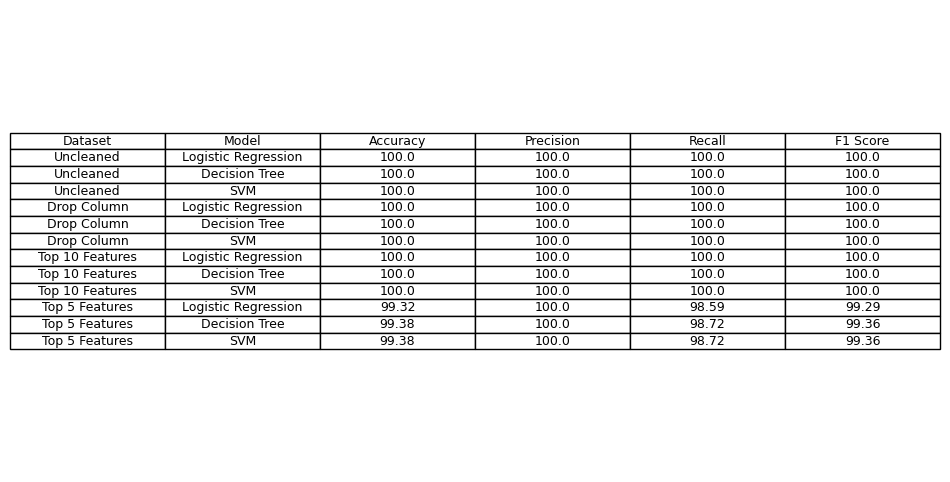

In [157]:
# Create a new DataFrame with the desired columns, excluding 'Confusion Matrix'
table_df = results_df.reset_index()
table_df.columns = ['Dataset', 'Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Confusion Matrix']
table_df = table_df.drop(columns=['Confusion Matrix'])

# Convert the metrics to percentages
table_df[['Accuracy', 'Precision', 'Recall', 'F1 Score']] = table_df[['Accuracy', 'Precision', 'Recall', 'F1 Score']] * 100

# Round the metrics to two decimal places
table_df[['Accuracy', 'Precision', 'Recall', 'F1 Score']] = table_df[['Accuracy', 'Precision', 'Recall', 'F1 Score']].round(2)

# Plot the table
fig, ax = plt.subplots(figsize=(12, 6))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=table_df.values, colLabels=table_df.columns, cellLoc='center', loc='center')

# Display the table
plt.show()

# Save the table to an image
fig.savefig('results_table.png')

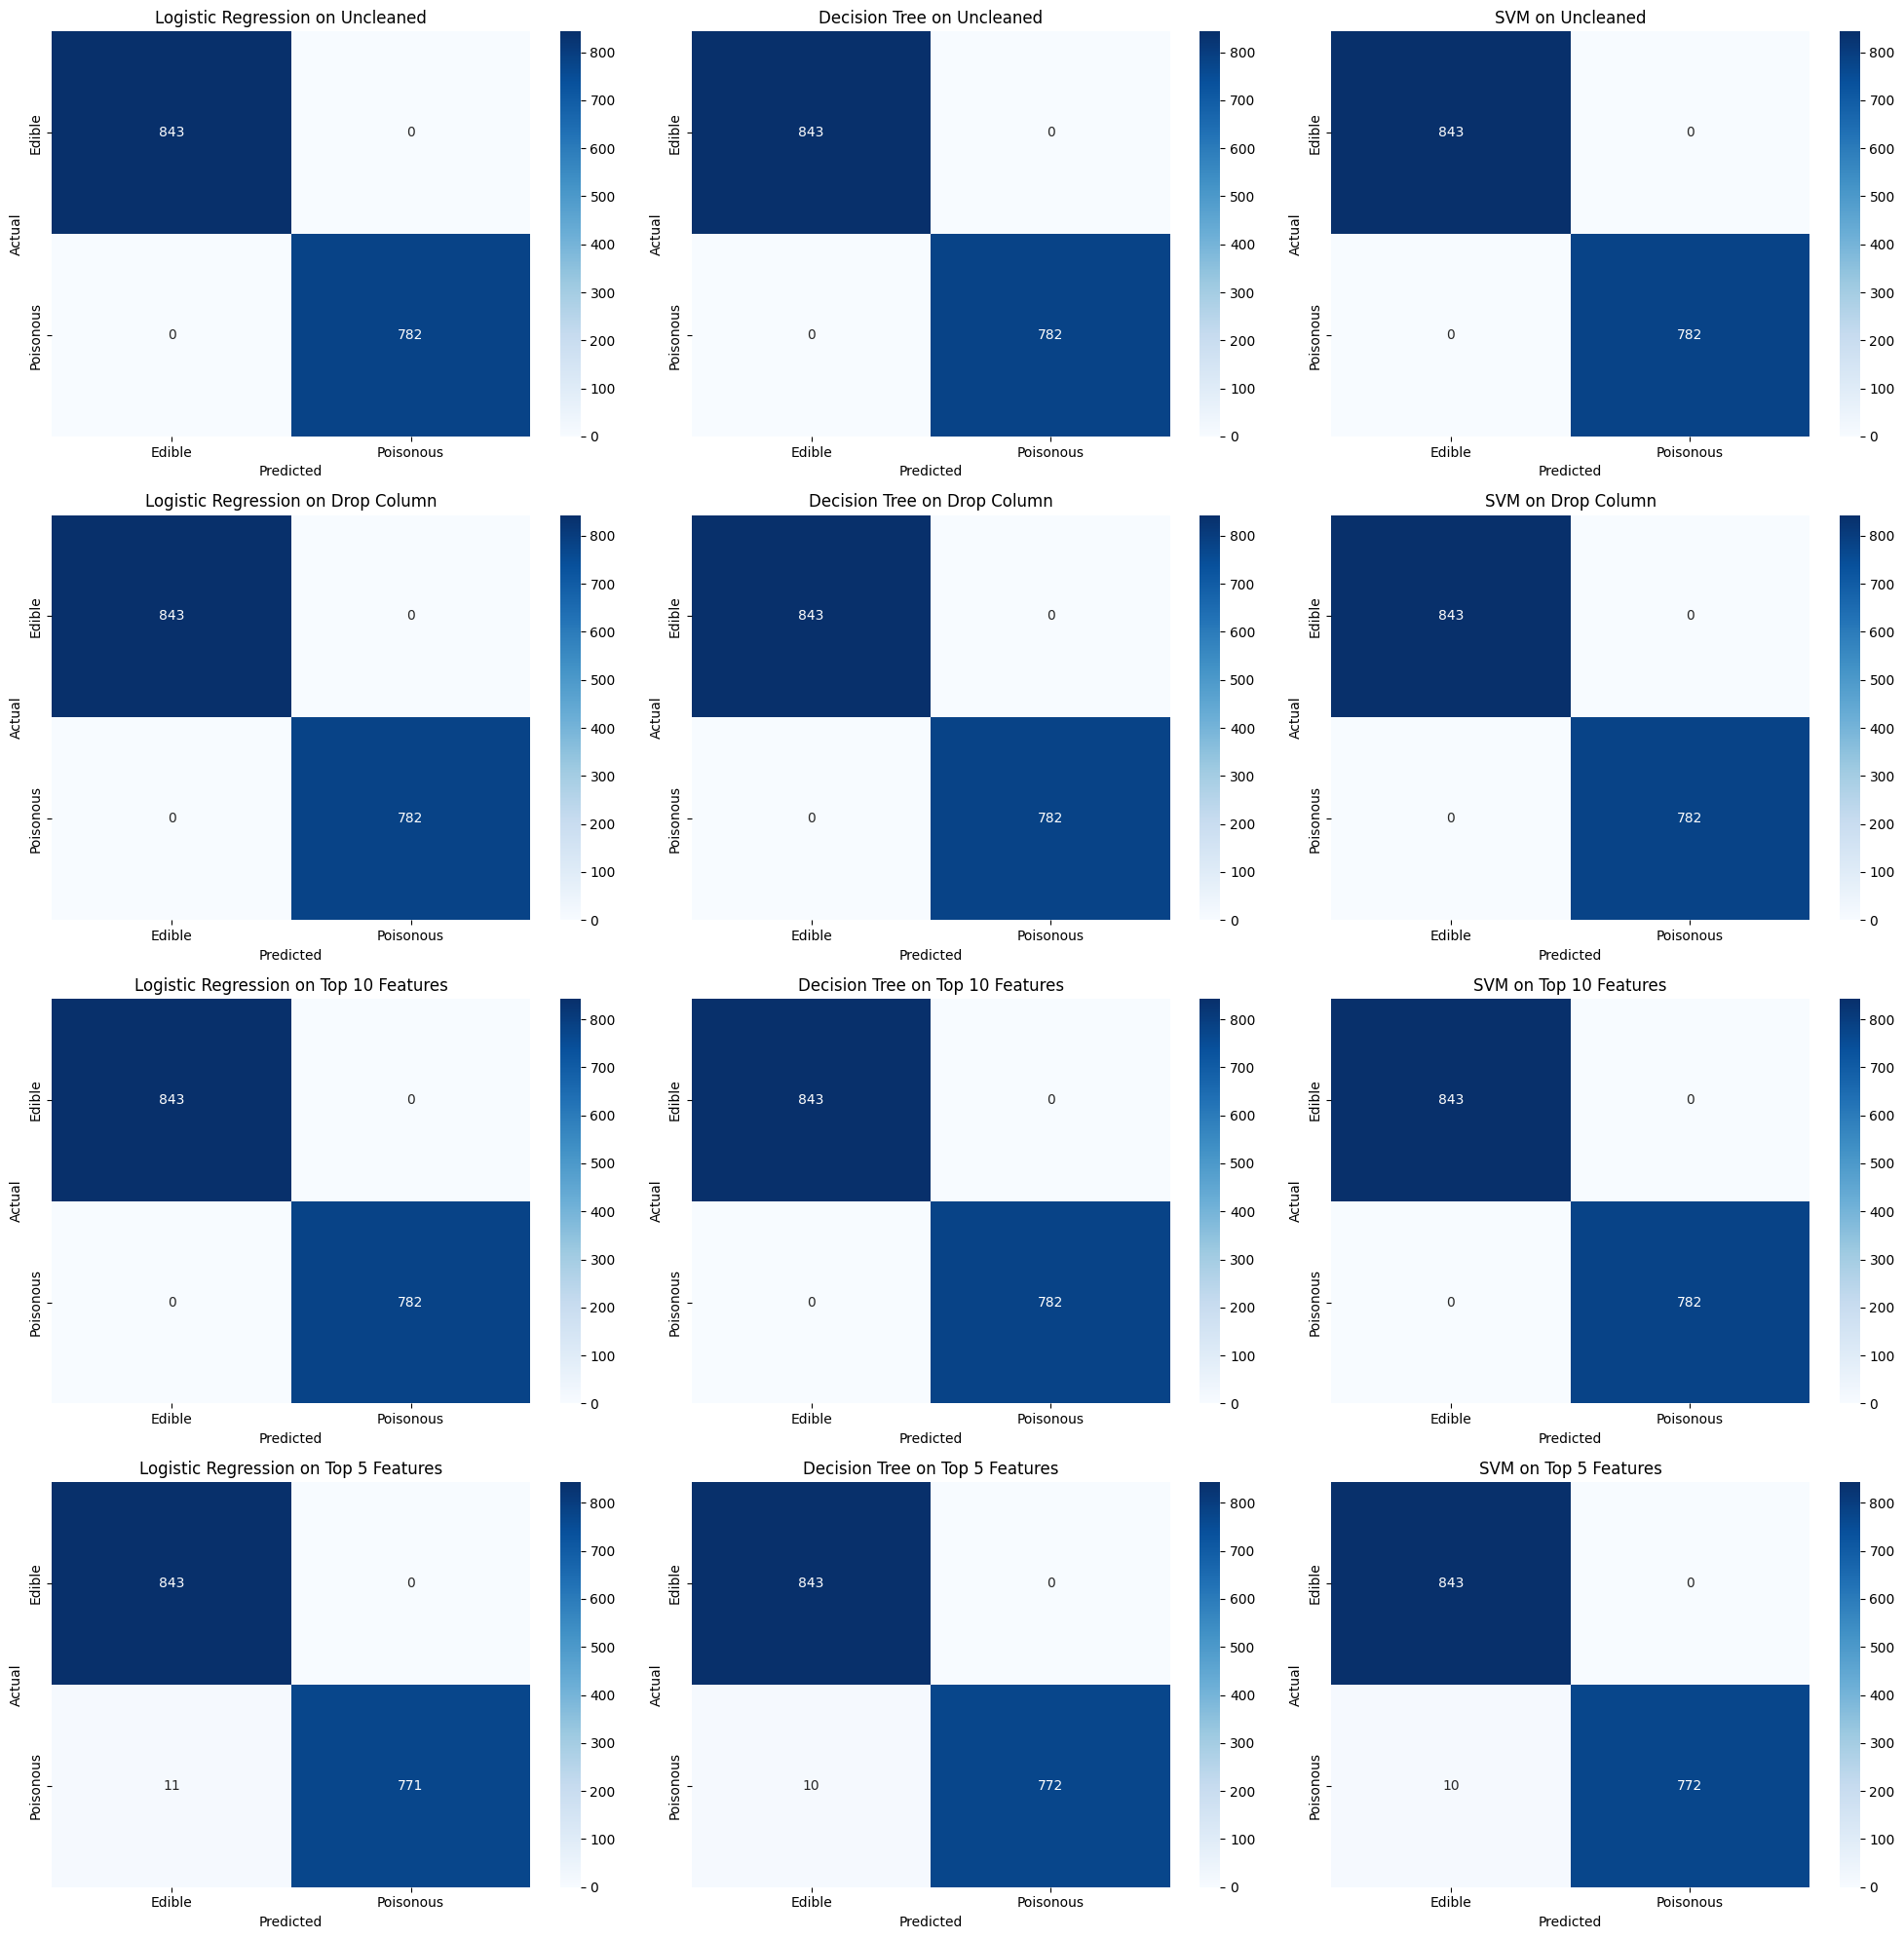

In [158]:
# Function to plot confusion matrix
def plot_confusion_matrix(ax, conf_matrix, model_name, dataset_name):
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Edible', 'Poisonous'], yticklabels=['Edible', 'Poisonous'], ax=ax)
    ax.set_title(f'{model_name} on {dataset_name}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

# Create a figure with 4 rows and 3 columns of subplots
fig, axes = plt.subplots(4, 3, figsize=(20, 20))
axes = axes.flatten()

# Plot confusion matrices for each model and dataset
index = 0
for dataset_name, results in all_results.items():
    for model_name, metrics in results.items():
        plot_confusion_matrix(axes[index], metrics['Confusion Matrix'], model_name, dataset_name)
        index += 1

# Adjust layout
plt.tight_layout()
plt.show()

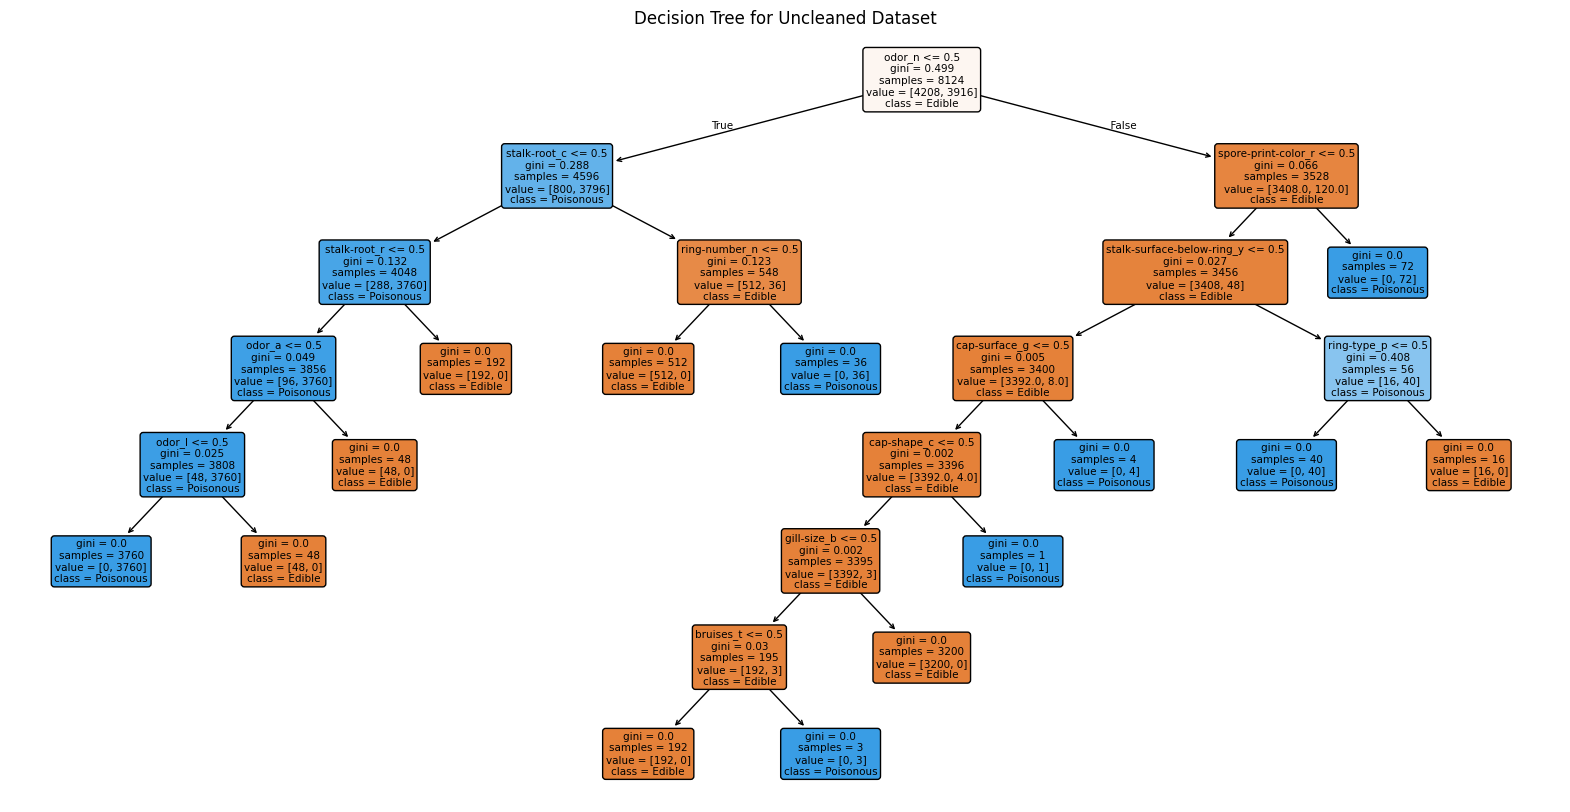

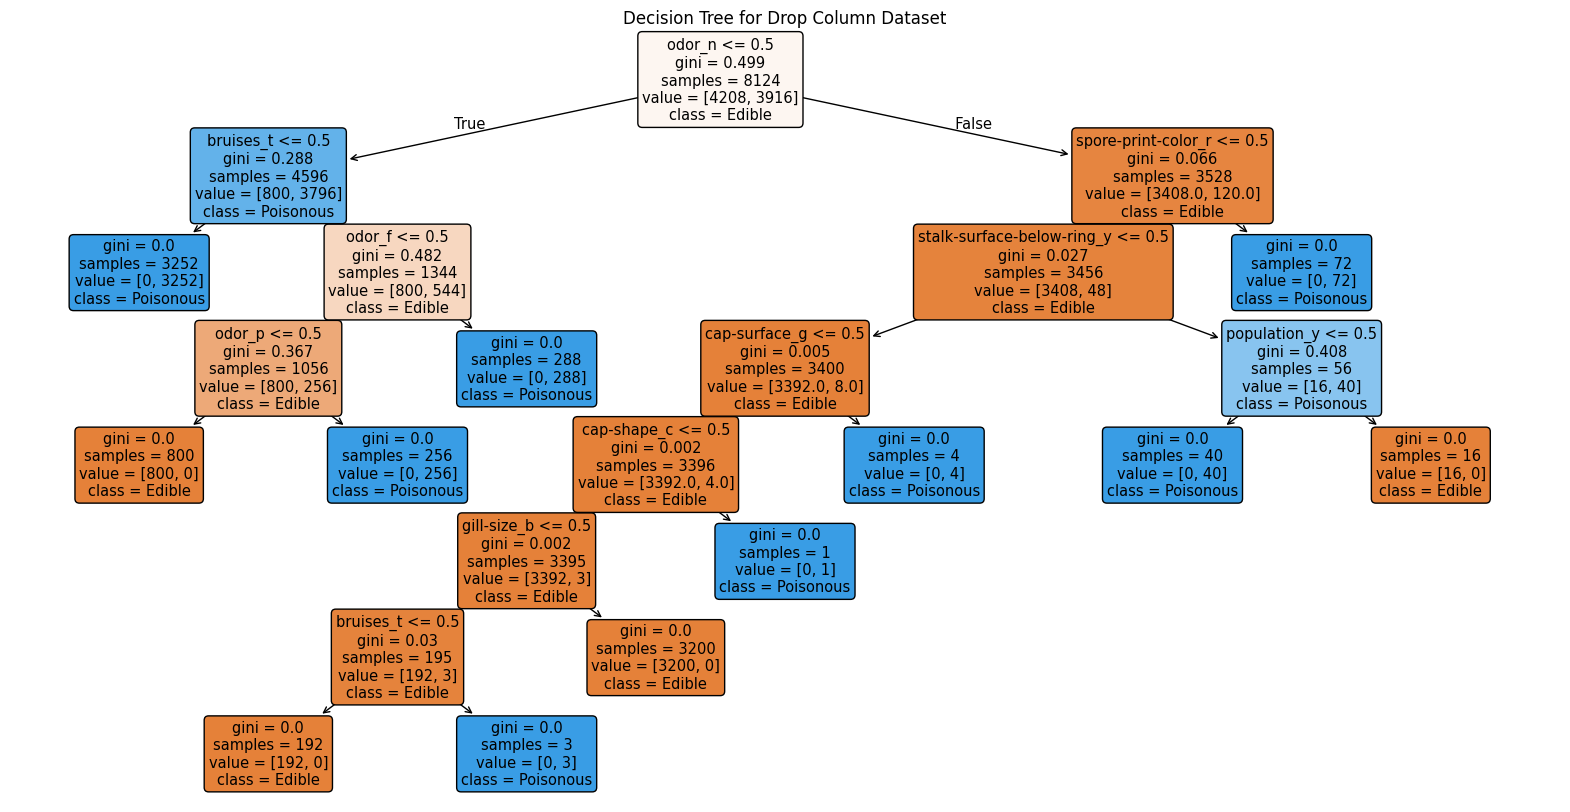

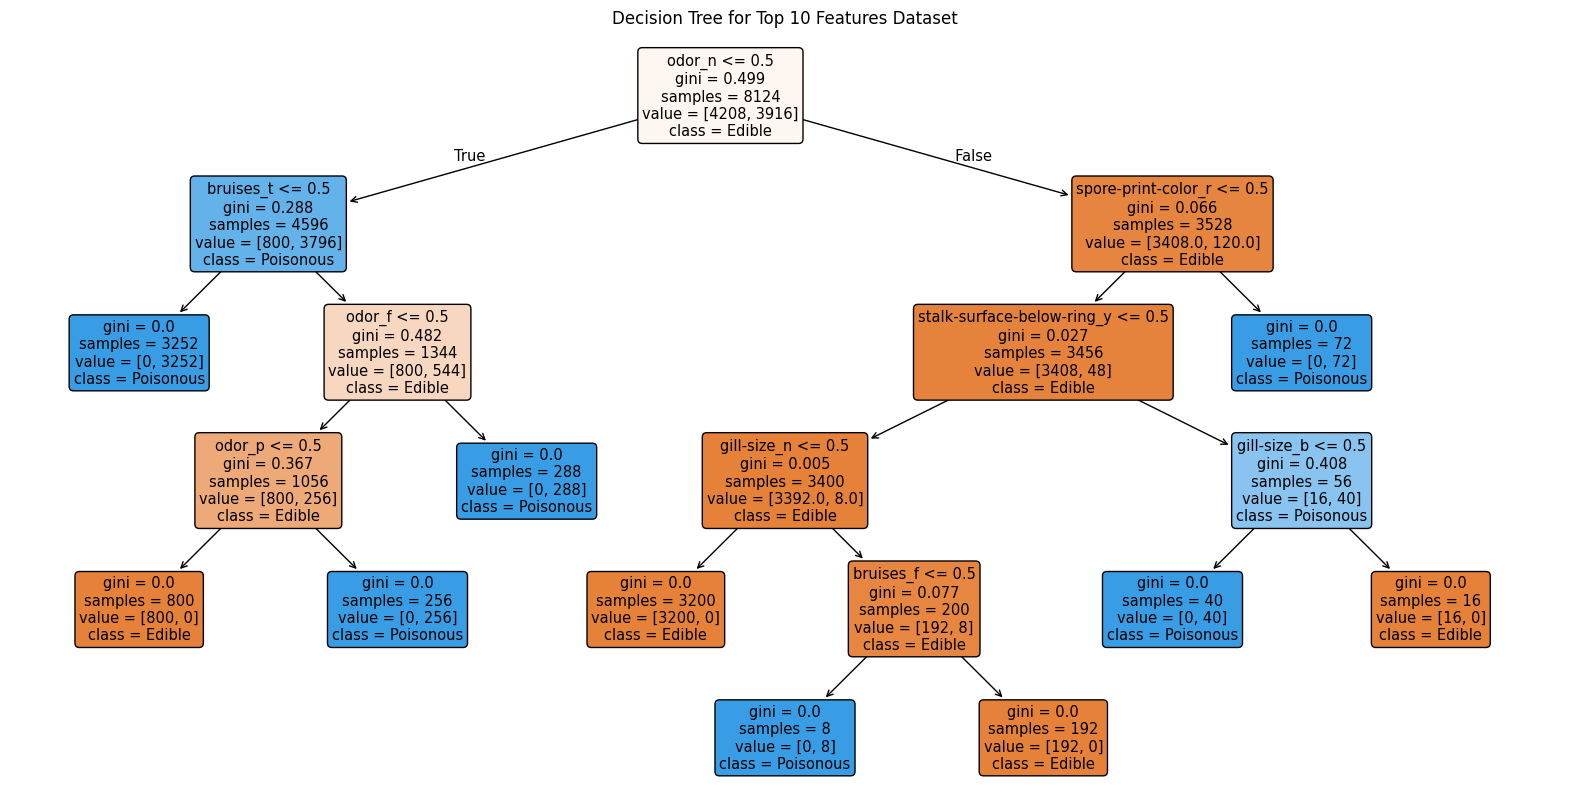

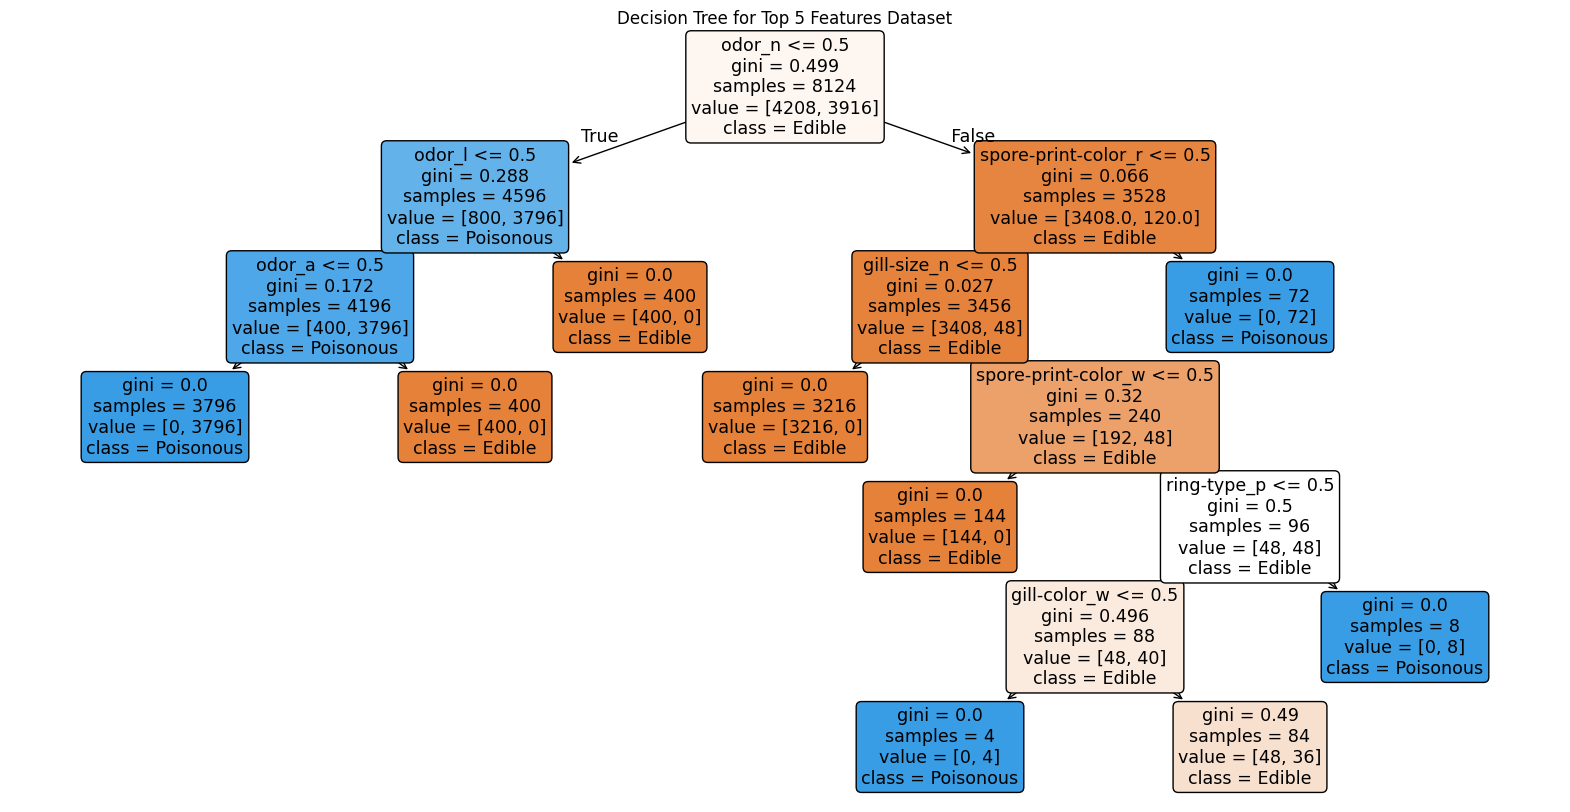

In [159]:

# Function to train and plot decision tree
def plot_decision_tree(x_train, y_train, dataset_name):
    # Initialize the model
    tree_model = DecisionTreeClassifier()
    
    # Fit the model
    tree_model.fit(x_train, y_train)
    
    # Plot the tree
    plt.figure(figsize=(20, 10))
    plot_tree(tree_model, filled=True, feature_names=x_train.columns, class_names=['Edible', 'Poisonous'], rounded=True)
    plt.title(f"Decision Tree for {dataset_name} Dataset")
    plt.show()

# Plot decision tree for each dataset
plot_decision_tree(x_uncleaned_encoded, y_encoded, 'Uncleaned')
plot_decision_tree(x_dropcolumn_encoded, y_encoded, 'Drop Column')
plot_decision_tree(x_top10_encoded, y_encoded, 'Top 10 Features')
plot_decision_tree(x_top5_encoded, y_encoded, 'Top 5 Features')